In [2]:
import sys
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
def visualize_temperatures(df_list, df_names, plot_type='histogram'):
    '''
    Compare the distribution of temperature labels in datasets
    Supported visualization formats:
     - histogram
     - violin
    '''
    temperatures = np.concatenate([df['fact_temperature'] for df in df_list])
    names = np.concatenate([[name]*len(df) for name, df in zip(df_names, df_list)])

    df_to_plot = pd.DataFrame(data={'Temperature': temperatures, 'Dataset Name':names})

    if plot_type == 'histogram':
        sns.histplot(
            data=df_to_plot, x="Temperature", hue="Dataset Name",
            element="step", stat="density", common_norm=False)
    elif plot_type == 'violin':
        sns.violinplot(x='Temperature', y='Dataset Name',
                              data=df_to_plot, scale='width', palette='Set3')
    else:
        raise ValueError("Unsupported plot_type")
    
    plt.show()
    plt.clf()

In [4]:
DATA_PATH = '/workspace/TSDataset/canonical_data'

df_train = pd.read_csv(DATA_PATH + '/train.csv')
df_train.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,...,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1.543321e+09,26.968800,-99.248901,2.0,0.0,dry,127.0,-17.526443,14.613571,754.263405,...,0.0,0.0,0.0,0.0,0.0,0.0,-2.600006,-2.750006,0.0,0.0
1,1.538776e+09,29.374201,-100.927002,31.0,20.0,mild temperate,297.0,41.531032,26.992143,733.117168,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.600006,17.950006,-12.0,11.0
2,1.552115e+09,22.149599,113.592003,17.0,10.0,mild temperate,-1.0,43.916531,18.842143,761.571076,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.233978,21.450006,1.0,8.0
3,1.549566e+09,34.678699,-86.684799,24.0,20.0,mild temperate,193.0,40.240955,8.303571,747.524910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.059448,16.150018,-58.0,41.0
4,1.552910e+09,46.066667,41.966667,9.0,20.0,dry,90.0,30.394660,6.451429,753.168113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.400024,3.150018,18.0,92.0


In [5]:
df_dev_in = pd.read_csv(DATA_PATH + '/dev_in.csv')
df_dev_out = pd.read_csv(DATA_PATH + '/dev_out.csv')

In [6]:
df_names = ['train', 'dev_in', 'dev_out']
df_list = [df_train, df_dev_in, df_dev_out]

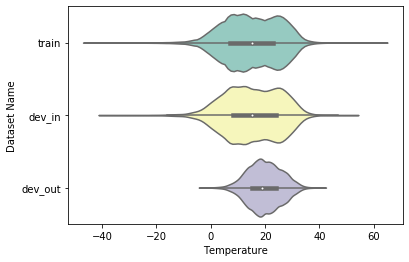

<Figure size 432x288 with 0 Axes>

In [7]:
visualize_temperatures(df_list, df_names, plot_type='violin')

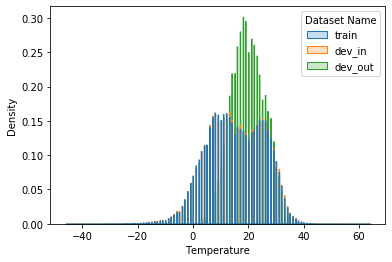

<Figure size 432x288 with 0 Axes>

In [8]:
visualize_temperatures(df_list, df_names, plot_type='histogram')

In [9]:
X_train = df_train.iloc[:,6:]
X_dev_in = df_dev_in.iloc[:,6:]
y_train = df_train['fact_temperature']
y_dev_in = df_dev_in['fact_temperature']

In [10]:
# Set training hyperparameters (note these are dummy hyperparameters - you will need to select your own)
ensemble_size = 3
depth = 2
iterations = 200
learning_rate = 0.03

In [17]:
X_train.shape

(3129592, 123)

In [20]:
!pip install catboost

     |████████████████████████████████| 67.4MB 65.7MB/s eta 0:00:01   |█                               | 2.2MB 1.3MB/s eta 0:00:51     |██                              | 4.4MB 1.3MB/s eta 0:00:50
     |████████████████████████████████| 20.6MB 19.2MB/s eta 0:00:01


In [21]:
import catboost

In [22]:
trained_models = []
for seed in range(ensemble_size):
    
    model = catboost.CatBoostRegressor(
        learning_rate = learning_rate,
        iterations = iterations,
        depth = depth,
        loss_function = 'RMSEWithUncertainty',
        eval_metric = 'RMSE',
        random_seed = seed)
    
    print(f'\n Model index: {seed}\n')
    
    model.fit(
        X_train,
        y_train,
        verbose = 100,
        eval_set = (X_dev_in, y_dev_in))
    
    trained_models.append(model)


 Model index: 0

0:	learn: 10.0772485	test: 10.0762054	best: 10.0762054 (0)	total: 372ms	remaining: 1m 14s
100:	learn: 2.8933962	test: 2.8692723	best: 2.8692723 (100)	total: 28.4s	remaining: 27.8s
199:	learn: 2.4636227	test: 2.4470545	best: 2.4470545 (199)	total: 54.1s	remaining: 0us

bestTest = 2.447054531
bestIteration = 199


 Model index: 1

0:	learn: 10.0797424	test: 10.0788222	best: 10.0788222 (0)	total: 306ms	remaining: 1m
100:	learn: 2.8958509	test: 2.8717422	best: 2.8717422 (100)	total: 28s	remaining: 27.4s
199:	learn: 2.4668849	test: 2.4504754	best: 2.4504754 (199)	total: 53.2s	remaining: 0us

bestTest = 2.450475398
bestIteration = 199


 Model index: 2

0:	learn: 10.0766372	test: 10.0755385	best: 10.0755385 (0)	total: 292ms	remaining: 58s
100:	learn: 2.8947113	test: 2.8704513	best: 2.8704513 (100)	total: 27.7s	remaining: 27.2s
199:	learn: 2.4646485	test: 2.4479654	best: 2.4479654 (199)	total: 52.5s	remaining: 0us

bestTest = 2.447965358
bestIteration = 199



In [26]:
dir_path = './save_'
if not os.path.exists(dir_path):
    os.mkdir(dir_path)
for i, model in enumerate(trained_models):
    model.save_model(f'{dir_path}/model{i+1}.cbm')

In [30]:
df_train.iloc[0]['fact_temperature']

2.0

In [32]:
for k in df_train.iloc[0].keys():
    print(k)

fact_time
fact_latitude
fact_longitude
fact_temperature
fact_cwsm_class
climate
topography_bathymetry
sun_elevation
climate_temperature
climate_pressure
cmc_0_0_0_1000
cmc_0_0_0_2_grad
cmc_0_0_0_2_interpolated
cmc_0_0_0_2_next
cmc_0_0_0_2
cmc_0_0_0_500
cmc_0_0_0_700
cmc_0_0_0_850
cmc_0_0_0_925
cmc_0_0_6_2
cmc_0_0_7_1000
cmc_0_0_7_2
cmc_0_0_7_500
cmc_0_0_7_700
cmc_0_0_7_850
cmc_0_0_7_925
cmc_0_1_0_0
cmc_0_1_11_0
cmc_0_1_65_0
cmc_0_1_66_0
cmc_0_1_67_0
cmc_0_1_68_0
cmc_0_1_7_0
cmc_0_2_2_10
cmc_0_2_2_1000
cmc_0_2_2_500
cmc_0_2_2_700
cmc_0_2_2_850
cmc_0_2_2_925
cmc_0_2_3_10
cmc_0_2_3_1000
cmc_0_2_3_500
cmc_0_2_3_700
cmc_0_2_3_850
cmc_0_2_3_925
cmc_0_3_0_0
cmc_0_3_0_0_next
cmc_0_3_1_0
cmc_0_3_5_1000
cmc_0_3_5_500
cmc_0_3_5_700
cmc_0_3_5_850
cmc_0_3_5_925
cmc_0_6_1_0
cmc_available
cmc_horizon_h
cmc_precipitations
cmc_timedelta_s
gfs_2m_dewpoint
gfs_a_vorticity
gfs_available
gfs_cloudness
gfs_clouds_sea
gfs_horizon_h
gfs_humidity
gfs_precipitable_water
gfs_precipitations
gfs_pressure
gfs_r_vel

In [37]:
int(df_train['fact_time'][0])

1543320900

In [43]:
import datetime
import time

In [54]:
timestamp = df_train['fact_time'][2]
datetimeobj = datetime.datetime.fromtimestamp(timestamp)

In [53]:
datetimeobj

datetime.datetime(2018, 10, 5, 21, 53)

In [55]:
datetimeobj

datetime.datetime(2019, 3, 9, 7, 0)